In [1]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

from gradvi.tests import toy_data
from gradvi.tests import toy_priors
from gradvi.inference import LinearRegression
from gradvi.inference import Trendfiltering
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma

from mrashpen.utils import R_trendfilter

In [14]:
np.random.seed(100)

#dims = np.power(2, 7 + np.arange(2))
n = 4096
data = dict()
degree = 0
nknots = 20
strue  = 0.6
knots  = np.linspace(0, 1, nknots+2)[1:-1]

# Gamma signal
def sample_sign(n, f = 0.5):
    return np.random.choice([-1, 1], size=n, p=[f, 1 - f])
params = [10, 0.1]
np.random.seed(100)
bfix = np.random.gamma(params[0], params[1], size = nknots + degree)
bfix = np.multiply(bfix, sample_sign(nknots + degree))


x = np.linspace(0, 1, n)
data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                signal = "fixed", seed = 100, bfix = bfix,
                include_intercept = False)

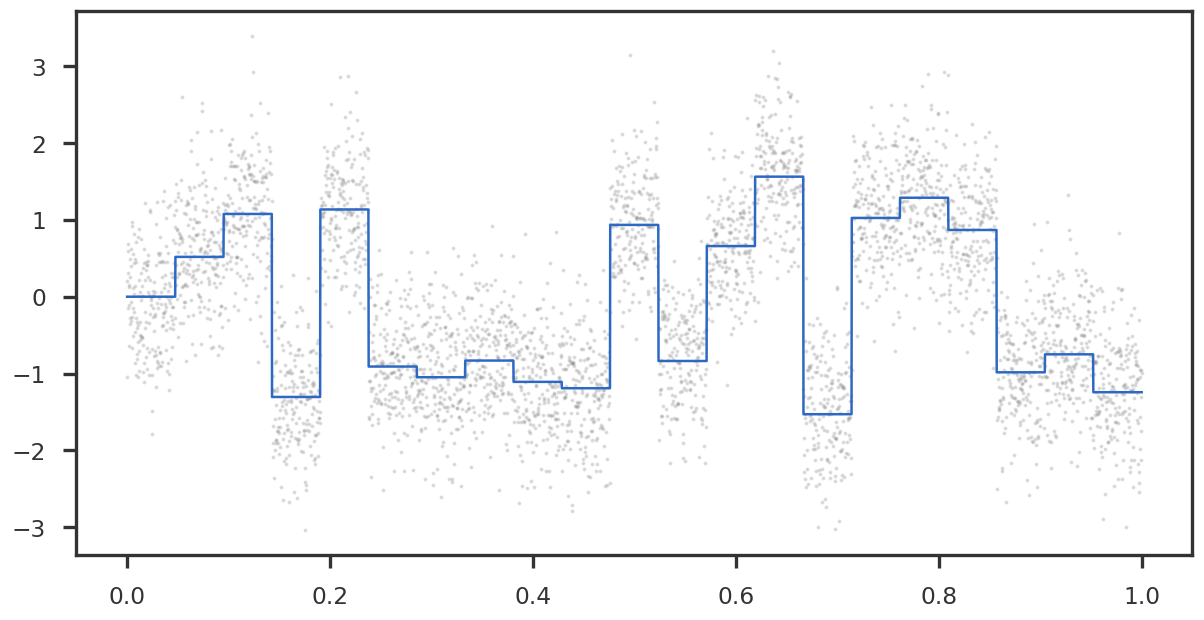

In [15]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'grey', alpha = 0.2)
ax1.plot(data.x, data.ytrue)
plt.show()

In [16]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)
tf_bhat  = np.dot(data.Hinv, tf_y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [17]:
## Genlasso Init

prior_init = toy_priors.get_ash(k = 20, sparsity = 0.9, skbase = 2.0, skfactor = 10.)
gv = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = True)
gv.fit(data.y, 0, prior_init, y_init = tf_y)
print (f"GradVI terminated in {gv.niter} iterations.")

GradVI terminated in 1137 iterations.


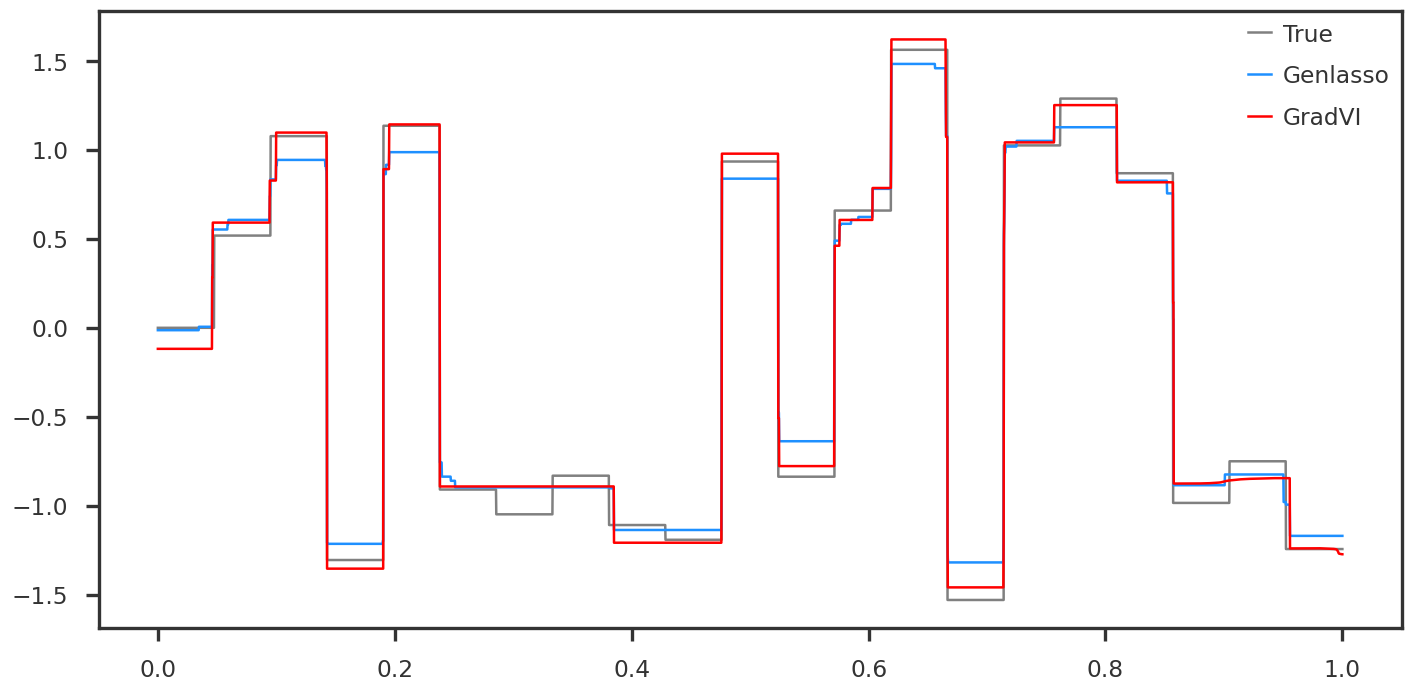

In [18]:
fig = plt.figure(figsize = (12, 6))
ax  = fig.add_subplot(1,1,1)
ax.plot(data.x, data.ytrue, label = 'True', color = 'grey')
#ax.scatter(data.x, data.y, s = 1, color = 'gray', alpha = 0.2)
ax.plot(data.x, tf_y, label = 'Genlasso', color = 'dodgerblue')
ax.plot(data.x, gv.ypred, label = 'GradVI', color = 'red')
ax.legend()

fig.tight_layout()
#fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
plt.show()

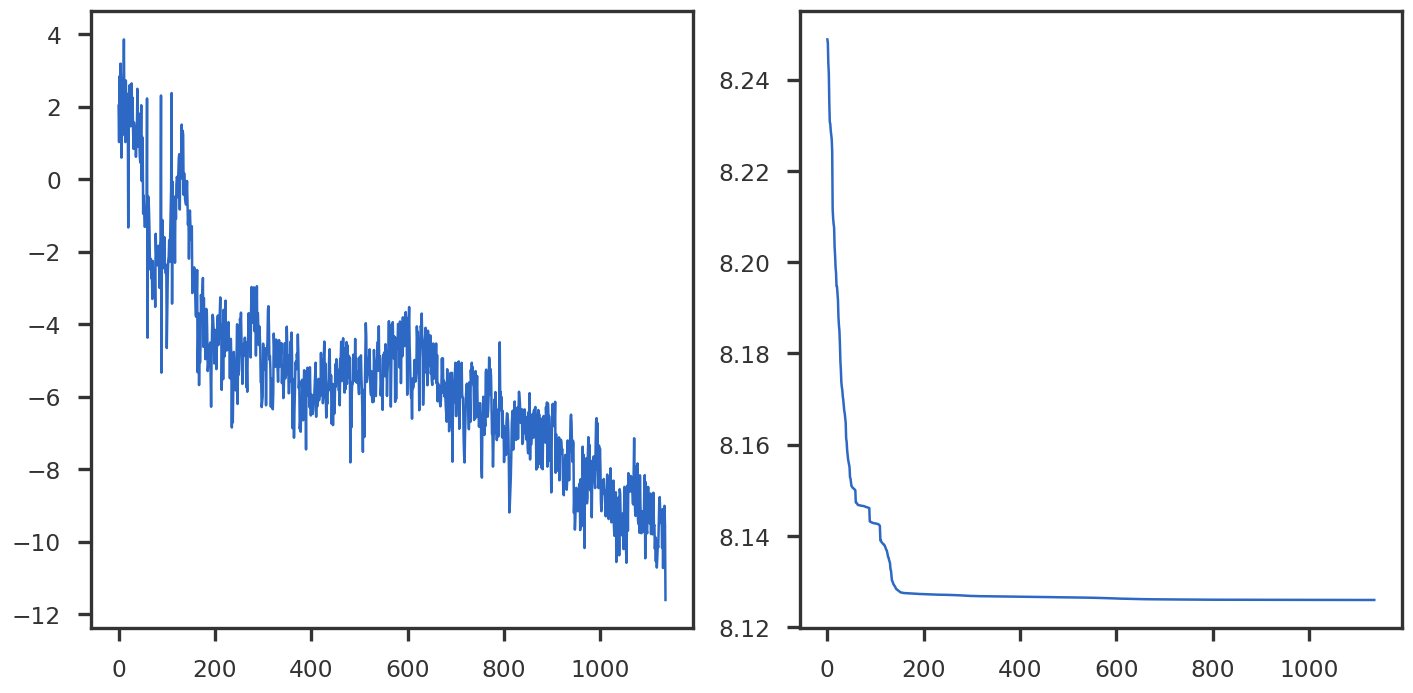

In [19]:
fig = plt.figure(figsize = (12, 6))

log_objdiff = np.log(-np.diff(gv.obj_path))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(np.arange(gv.niter - 1), log_objdiff)
ax2.plot(np.arange(gv.niter - 1), np.log(gv.elbo_path[1:]))

fig.tight_layout()
plt.show()